# Co-drying of methanol and toluol from poly-(vinylacetate)

This jupyter notebook models the co-drying of two solvents from a polymer. First we import the diffusion model and the pc-saft implementation from diffusionpy

In [1]:
import numpy as np
from diffusionpy import Diffusion_MS,mixture
import matplotlib.pyplot as plt

The experimental data which is defined in the cell below  was taken from Schabel et al. (https://doi.org/10.1016/j.ces.2006.12.062)

In [2]:
#time in minutes
#drying kinetics
texp=np.asarray([0,4.427792916,14.50035208,23.87257753,33.76909653,45.58674953,58.69408811,71.80142669,91.44521324,120.9089796,147.0930411,177.8656278,212.5493678,264.9136638,429.8518201])
wpvac=np.asarray([0.333333333,0.397028757,0.559683846,0.704648614,0.763915741,0.791401827,0.801167219,0.822653035,0.830878575,0.841458325,0.846286716,0.857199094,0.851138308,0.858388537,0.8723936549])
wtol=np.asarray([0.333333333,0.361083897,0.34858624,0.273123698,0.22781745,0.202716913,0.188759833,0.17692216,0.169121425,0.158541675,0.153713284,0.142800906,0.143816828,0.137082518,0.123003508])
wmet=np.asarray([0.333333333,0.241887346,0.091729914,0.022227687,0.008266808,0.00588126,0.010072947,0.000424805,0,0,0,0,0,0,0])

The drying starts from a mixture of methanol-toloul-PVAc in equal parts and ends with a remaining pvac-toluol mixture. We define the temperature, the presssure, the number of components, their molar mass and the starting and equilibrium weight fractions.

In [3]:
T=298.15
p=1E5
L=2.32E-5
wi0=np.asarray([0.333333333,0.333333333,0.333333333]) # Weight fractions of the components methanol, toluol and PVAc at t=0
wi8=np.asarray([0.0001,0.127606346,0.872393654]) # Weight fractions of the components methanol, toluol and PVAc at t=infty
wi8=wi8/np.sum(wi8) # norming so that the sum of all mole fraction equals one just in case
wi0=wi0/np.sum(wi0)
Mi=np.asarray([32.04,92.14,90000.])

For describing the diffusion in the mixture, a matrix of diffusion coefficients needs to be defined. The matrix for a ternary system is displayed below:


$\hat{Ð} =$ 
$\left[\begin{array}{rrr} 
0 & Ð_{12} & Ð_{13} \\ 
Ð_{21} & 0 & Ð_{23} \\ 
Ð_{31} & Ð_{32} & 0 \\ 
\end{array}\right]$

where $\hat{Ð}$ is the matrix of diffusion coefficients and $Ð_{ij}$ are the binary diffusion coefficients of component i moving in j. Friction between the same species is not required, thus $Ð_{ii}=0$  
Furthermore, the Stefan-Maxwell diffusion coefficients have a symmetric property where for each pair of binary diffusion coefficients this relation holds $Ð_{ij}=Ð_{ji}$

Thus, for describing the diffusion in a ternary system, only three binary diffusion coefficients need to be defined:

$Ð_{vec} = \left[\begin{array}{rrr} Ð_{12} & Ð_{13} & Ð_{23} \end{array}\right]$


In [4]:
Dvec=np.asarray([1E-9,5E-11,1E-11])

Lastly, one needs to specify which components is considered mobile and which immobile. In our case, the solvents are  mobile while the polymer can be considered immobile. These properties are defined as a boolean array.

In [5]:
mobile=np.asarray([True,True,False])
mobiles=np.where(mobile)[0]

Finally, we can model solvent desorption. First in the ideal case and plot the results

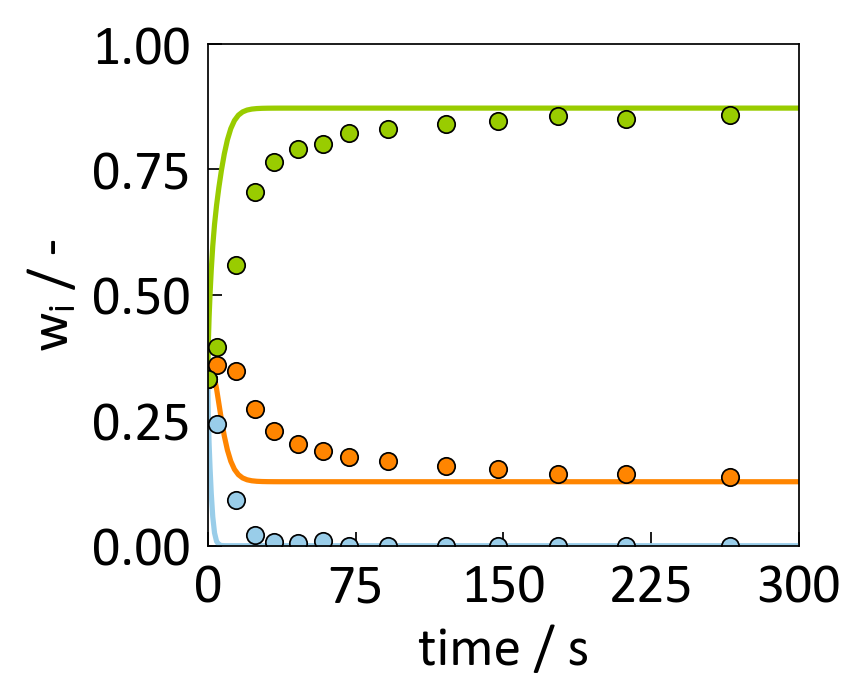

In [6]:
nt=80
t=np.linspace(0,texp[-1]**0.5,nt)**2    
wtid=Diffusion_MS(t,L,Dvec,wi0,wi8,mobile)[0]
def plot(wt):
    fig,ax=plt.subplots()
    ax.plot(t,wt[:,0],"C1-")
    ax.plot(t,wt[:,1],"C3-")
    ax.plot(t,wt[:,2],"C0-")
    ax.plot(texp,wmet,"C1o")
    ax.plot(texp,wtol,"C3o")
    ax.plot(texp,wpvac,"C0o")
    ax.set_xlabel("time / s")
    ax.set_ylabel("$w_i$ / -")
    ax.set_xticks([0.,75.,150.,225.,300.])
    ax.set_yticks([0.,0.25,0.5,0.75,1.])
    ax.set_xlim([0.,300.])
    ax.set_ylim([0,1.])
    plt.show()
plot(wtid)

diffusionpy neglects non-idealities for the default case. If the user wants to consider non-idealities a thermodynamic model is needed. 
diffusionpy comes prepackaged with an implementation of the pc-saft equation of state. 
PC-SAFT parameteters can be defined as follows:

In [7]:

par={"mi":np.asarray([1.5255, 2.8149, 2889.9]),
"si": np.asarray([3.2300, 3.7169, 3.3972]),
"ui" :np.asarray([188.9, 285.69, 204.65]),
"eAi" :np.asarray([2899.5, 0., 0.]),
"kAi":np.asarray([0.035176, 0., 0.]),
"NAi":np.asarray([1., 0., 1047.]),
"Mi": Mi,
"kij":np.asarray([0.029,-0.05855362,0.027776682]),
"kijA":np.asarray([0.,0.,0.])}



However, any other implementatation of any thermodyamic model can be used in conjucntion with diffusionpy. 
This is because, diffusionpy relies soley on the numerical values of second derivative of activities $a_i$ or fugacities $f_i$ of component i. 

$\frac{Dlna_i}{Dlnx_i}$ = $\frac{Dlnf_i}{Dlnx_i}$ , where $D$ denotes that the differentiation was performed while neglecting the mass balance.

The nonidealities employed in an iterative fashion and are supplied for each time point for the current weight fraction -time matrix. Here, the ideal solution from before gives the initial point for the iteration. 

In esssence, the iteration was performed by using a simple fixed point iteration. 
Additionally, full output can specified in order to recieve e.g the spatial information of the concentrations
We can plot the time and spatial profiles of methanol and toluene

C:\GitHub_Projects\diffusionpy\diffusionpy\diffusion.py:298: RuntimeWarning: invalid value encountered in divide
  a = df/dx
C:\GitHub_Projects\diffusionpy\diffusionpy\diffusion.py:298: RuntimeWarning: divide by zero encountered in divide
  a = df/dx
C:\GitHub_Projects\diffusionpy\diffusionpy\diffusion.py:299: RuntimeWarning: divide by zero encountered in divide
  q= np.average(np.fmin(np.fmax(np.nan_to_num(a/(a-1),nan=0,posinf=0,neginf=0),0),1))
C:\GitHub_Projects\diffusionpy\diffusionpy\diffusion.py:299: RuntimeWarning: invalid value encountered in divide
  q= np.average(np.fmin(np.fmax(np.nan_to_num(a/(a-1),nan=0,posinf=0,neginf=0),0),1))


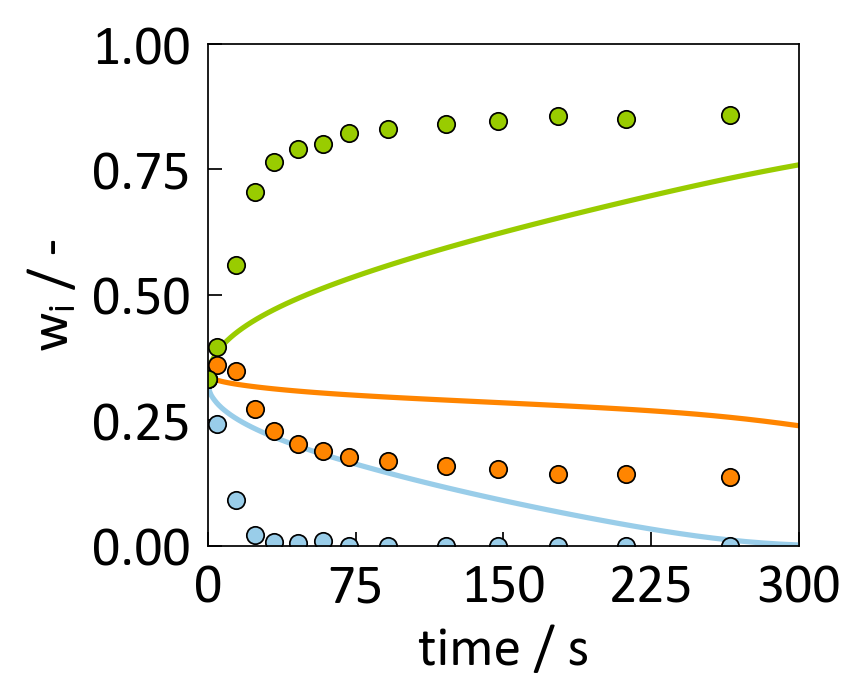

In [8]:
Dvec=np.asarray([1E-9,8E-12,2E-12])
wt,wtz,zvec,Lt=Diffusion_MS(t,L,Dvec,wi0,wi8,mobile,T=T,p=p,saftpar=par)
plot(wt)

Finally, diffusionpy provides an interface to change the boundary conditions. For example here, we provide a time-dependant surface cocnentartion to consider that the surface concentration needs time to establish due to gassided diffusion limitations

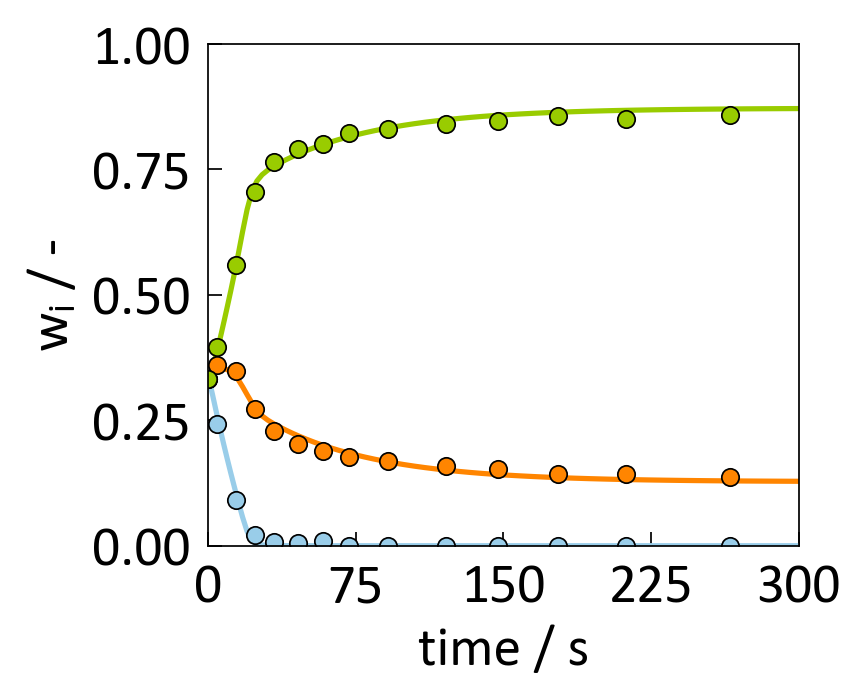

In [9]:
taui=np.asarray([5,55])
from diffusionpy.surface import time_dep_surface
witB=time_dep_surface(t,wi0,wi8,mobile,taui)
Dvec=np.asarray([1E-5,2E-10,2E-10])
wt,wtz,zvec,Lt=Diffusion_MS(t,L,Dvec,wi0,wi8,mobile,T=T,p=p,saftpar=par,taui=taui)
plot(wt)